In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot as ur
import pandas as pd

from os import listdir, mkdir
from os.path import isfile, join, basename, isdir

from convert_directory import convert_directory

In [2]:
source_path = "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")
in_file_location = "hGen"

In [103]:
type_map = {
    "int32_t": "i4"
}

def convert_type(type_name: str):
    if type_name in type_map:
        return type_map[type_name]
    else:
        return type_name

def convert_file(source_path, in_file_location, output_path = ""):
    with ur.open(source_path) as file:
        # Find data in file
        data = file[in_file_location]

        # Get correct column names and types for conversion
        dtype_arr = []
        dtype_names = data.typenames()

        for field_name in dtype_names:
            dtype_arr.append((field_name, convert_type(dtype_names[field_name])))

        # Convert data to (column-wise) arrays using numpy
        out = np.zeros(data.num_entries, dtype=dtype_arr)
        keys = data.keys()
        for i in range(0, len(keys)):
            key = keys[i]
            out[key] = data[key].array()

        if output_path != "":
            np.save(output_path, out, allow_pickle=True)

    return out

# See https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html
def convert_directory(source_path: str, in_file_location: str, output_dir_abs: str = ""):
    dir_contents = listdir(source_path)
    root_files = filter(lambda filename: filename.endswith(".root"), dir_contents)

    output_dir = source_path
    if output_dir_abs != "":
        output_dir = output_dir_abs

    if not isdir(output_dir_abs):
        mkdir(output_dir_abs)

    for filename in root_files:
        bname = basename(filename)
        output_path = join(output_dir, bname + ".npy")
        if isfile(output_path):
            print("Skipping file <" + bname + "> (exists)")
        else:
            convert_file(join(source_path, filename), in_file_location, output_path)


convert_directory(source_path, "eventTree", output_path)

In [104]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/.npy/output.root.npy']

In [105]:
data = pd.DataFrame(np.load(b[0], allow_pickle=True))
data.columns

Index(['run', 'event', 'passed_preselection', 'm_true_h1_decay_pdg',
       'm_true_h2_decay_pdg', 'true_sigma', 'true_sigmall', 'true_sigmalr',
       'true_sigmarl', 'true_sigmarr', 'true_mz', 'true_mhh', 'true_mzhh',
       'true_phi', 'true_costheta', 'reco_sigma', 'reco_sigmall',
       'reco_sigmalr', 'reco_sigmarl', 'reco_sigmarr', 'reco_mz', 'reco_mhh',
       'reco_mzhh', 'reco_phi', 'reco_costheta'],
      dtype='object')

In [106]:
data["sigma_ratio"] = data["reco_sigma"] / data["true_sigma"]
data["mz_ratio"] = data["reco_mz"] / data["true_mz"]

data["true_phi_wt"] = data["true_phi"] / data["true_sigmalr"]
data["reco_phi_wt"] = data["reco_phi"] / data["reco_sigmalr"]

data["true_mz_wt"] = data["true_mz"] / data["true_sigmalr"]
data["reco_mz_wt"] = data["reco_mz"] / data["reco_sigmalr"]

[Text(0.5, 1.0, 'passed_preselection')]

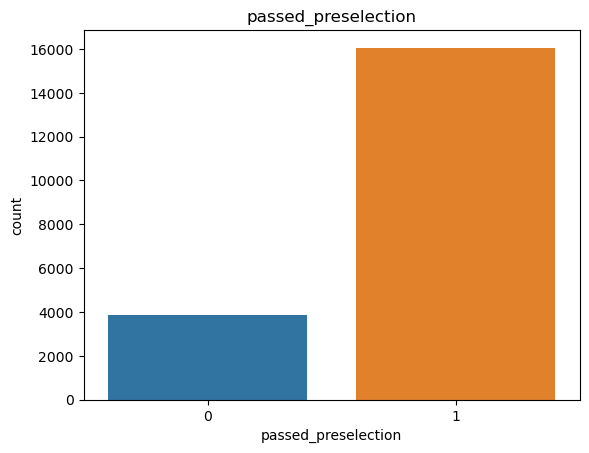

In [107]:
x = "passed_preselection"

#fig, axs = plt.subplots(ncols=3)
#f = sns.countplot(data, x=x1, ax=axs[0])
f = sns.countplot(data, x=x)
f.set(title=x)

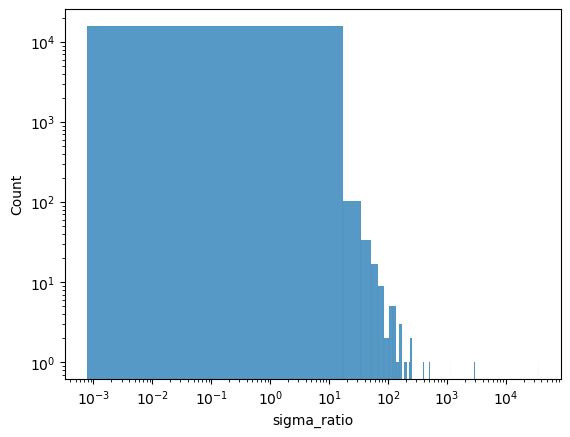

In [108]:
x = "sigma_ratio"

f = sns.histplot(data=data[data["passed_preselection"] == 1].dropna(), x=x, bins=2048)
f.set_yscale("log")
f.set_xscale("log")

In [109]:
data.head()

,run,event,passed_preselection,m_true_h1_decay_pdg,m_true_h2_decay_pdg,true_sigma,true_sigmall,true_sigmalr,true_sigmarl,true_sigmarr,...,reco_mhh,reco_mzhh,reco_phi,reco_costheta,sigma_ratio,mz_ratio,true_phi_wt,reco_phi_wt,true_mz_wt,reco_mz_wt
0,403001,1,1,5,5,4.069340e-14,3.552943e-15,7.860422e-14,7.876372e-14,1.852726e-15,...,307.026154,446.901337,-3.079209,0.658341,2.008289,1.005754,-3.638463e+13,-1.924244e+13,1.152185e+15,5.692205e+14
1,403001,2,1,21,21,7.931965e-14,2.042705e-13,2.737472e-15,2.752175e-15,1.075185e-13,...,299.286835,425.062439,-1.075820,0.002598,0.996751,0.993437,-6.055578e+14,-6.918456e+12,3.347196e+16,5.853838e+14
2,403001,3,1,5,5,2.001587e-14,1.842408e-14,2.597875e-14,2.596317e-14,9.697490e-15,...,309.041565,483.490875,-1.056400,0.899296,1.798155,1.006597,-4.435455e+13,-2.224379e+13,3.472427e+15,1.911997e+15
3,403001,4,1,5,24,2.711904e-16,7.092752e-16,1.012994e-18,1.001357e-18,3.734722e-16,...,367.116302,472.364105,-1.489111,-0.203174,0.476201,0.999254,1.372745e+17,-5.929084e+15,7.168607e+19,2.889204e+17
4,403001,5,1,5,5,7.656955e-16,1.376326e-17,1.521178e-15,1.520468e-15,7.372861e-18,...,301.307892,435.992157,2.496945,0.643037,1.694688,1.003574,1.591160e+15,9.709764e+14,5.336387e+16,3.167936e+16


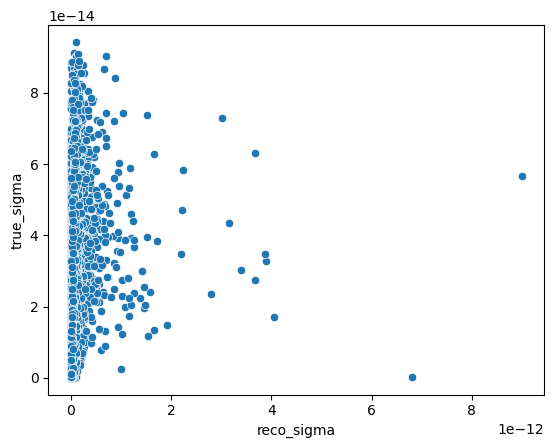

In [68]:
x = "sigma_ratio"

f = sns.scatterplot(data=data[data["passed_preselection"] == 1], x="reco_sigma", y="true_sigma")
#f.set(xlim=(10**-12, 1), ylim=(10**-12, 1), yscale="log", xscale="log")

In [1]:
data_zhh = pd.DataFrame(np.load(b[3], allow_pickle=True))
data_zhh["type"] = "zhh"
data_zhh.columns

NameError: name 'pd' is not defined

<Axes: xlabel='actual_zdecay_pdg', ylabel='count'>

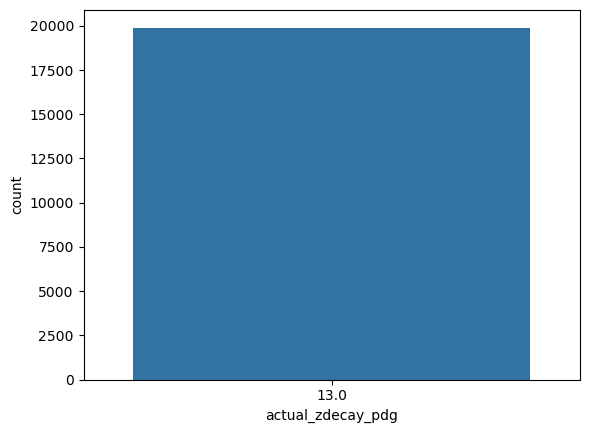

In [84]:
sns.countplot(data_zhh, x="actual_zdecay_pdg")

In [85]:
data = pd.concat([data_zzh, data_zhh])

In [86]:
data.columns

Index(['sigma', 'sigmalll', 'sigmallr', 'sigmalrl', 'sigmalrr', 'sigmarll',
       'sigmarlr', 'sigmarrl', 'sigmarrr', 'mzz', 'mz1', 'mz2', 'mzzh',
       'costheta', 'phi', 'costhetaz', 'phiz', 'costhetaz1f', 'phiz1f',
       'costhetaz2f', 'phiz2f', 'corr_pdgs', 'actual_z1decay_pdg',
       'actual_z2decay_pdg', 'type', 'sigmall', 'sigmarl', 'sigmalr',
       'sigmarr', 'mz', 'mhh', 'mzhh', 'costhetaf', 'phif', 'costhetah',
       'phih', 'actual_zdecay_pdg'],
      dtype='object')

[Text(0.5, 0, 'sigma')]

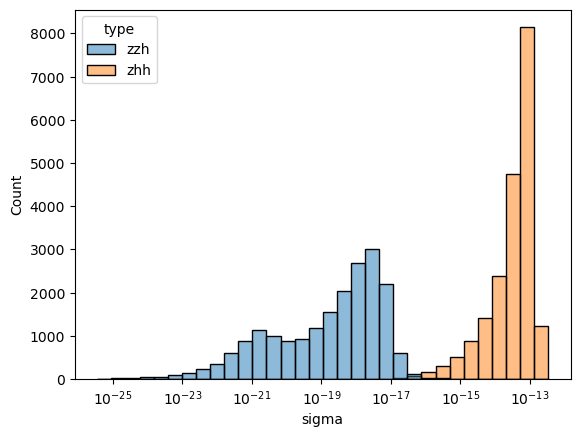

In [87]:
x = "sigma"
f = sns.histplot(data, x=x, hue="type", bins=32, log_scale=True)
f.set(xlabel=x)

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zhh')]

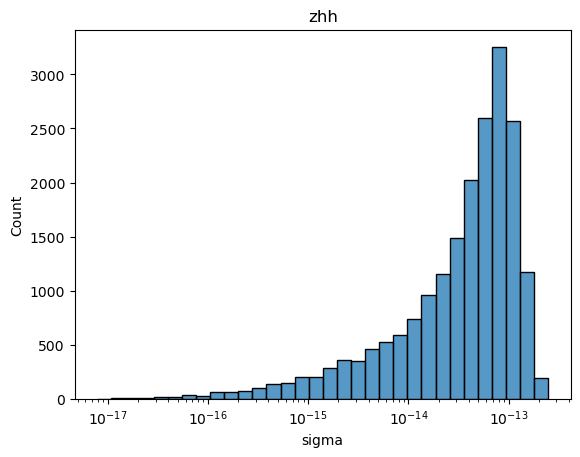

: 

In [88]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zhh"], x="sigma", bins=32, log_scale=True)
f.set(xlabel=x, title="zhh")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar')]

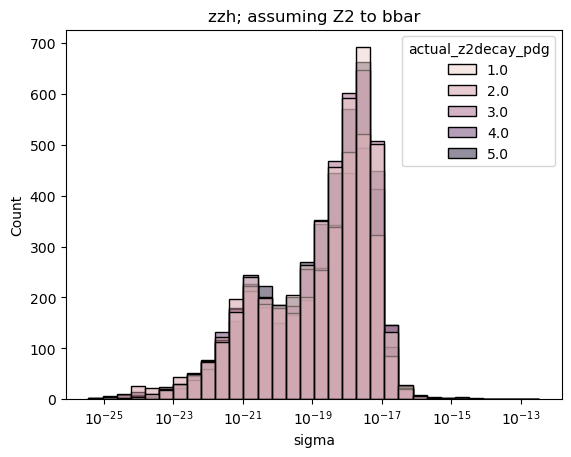

In [56]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zzh"], x="sigma", hue="actual_z2decay_pdg", bins=32, log_scale=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh mz1,mz2')]

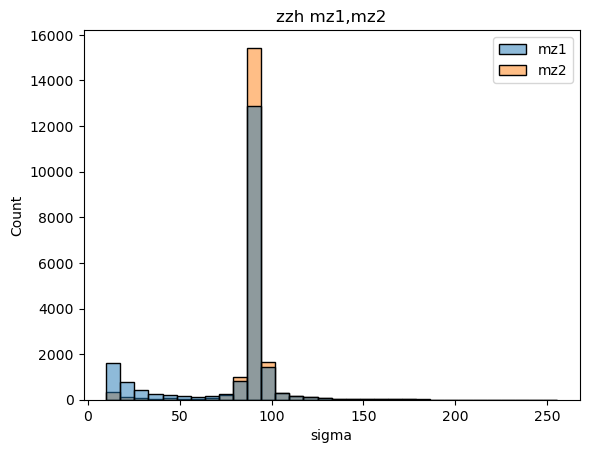

In [76]:
x = "sigma"
y = ["mz1", "mz2"]
f = sns.histplot(data[data["type"] == "zzh"][y], bins=32)
f.set(xlabel=x, title="zzh " + ",".join(y))

[Text(0.5, 0, 'mz1'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar'), None]

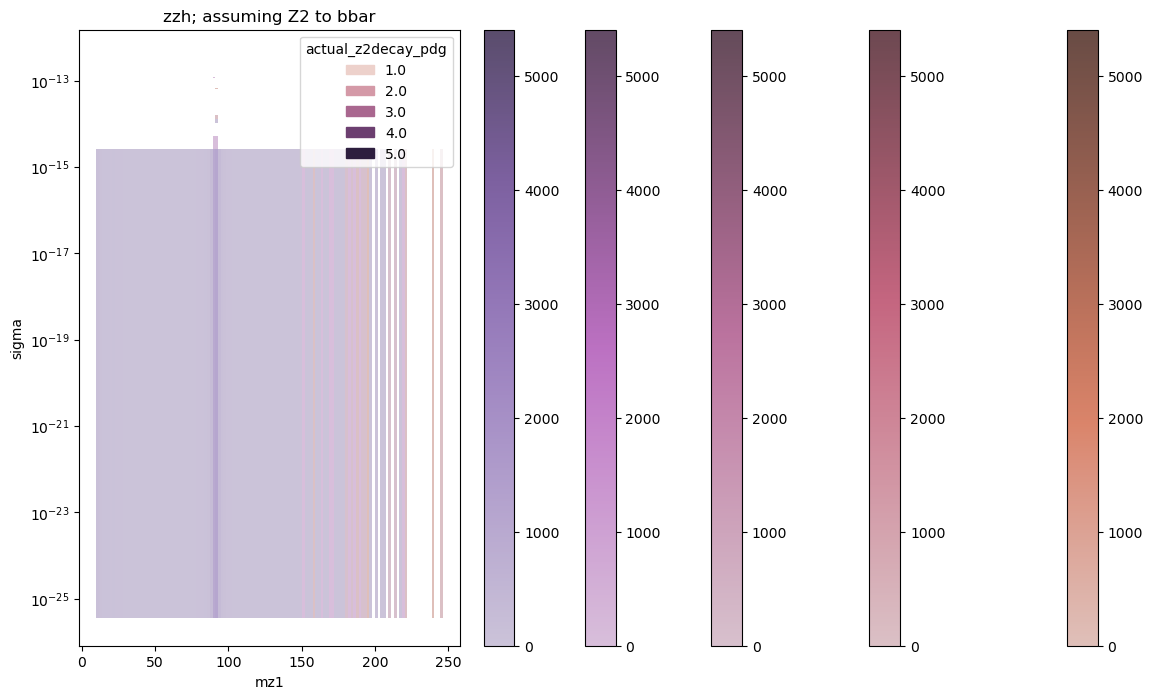

In [74]:
x = "mz1"
y = "sigma"

plt.figure(figsize=(15,8))
f = sns.histplot(data[data["type"] == "zzh"], x=x, y=y, hue="actual_z2decay_pdg", bins=128, cbar=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar", yscale="log")

[Text(0.5, 0, 'mz'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH')]

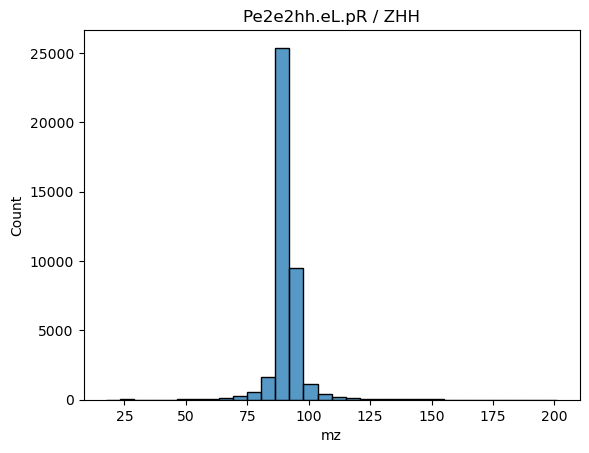

In [59]:
x = "mz"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2hh.eL.pR / ZHH")

[Text(0.5, 0, 'mhh'), Text(0.5, 1.0, 'Pe2e2ffqqH.eL.pR / ZHH')]

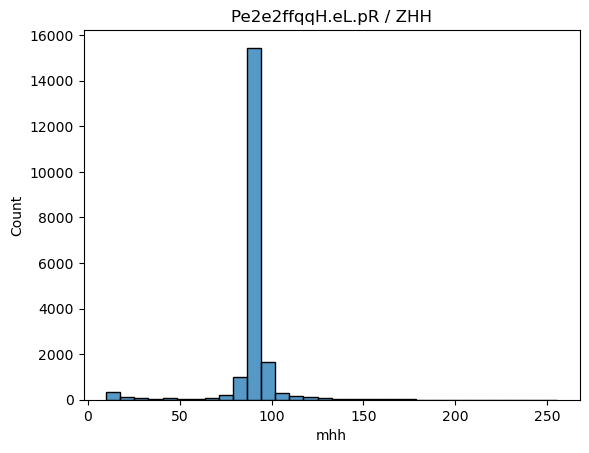

In [15]:
x = "mhh"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2ffqqH.eL.pR / ZHH")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 (-3.0, 3.0),
 (80.0, 102.0),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH unweighted')]

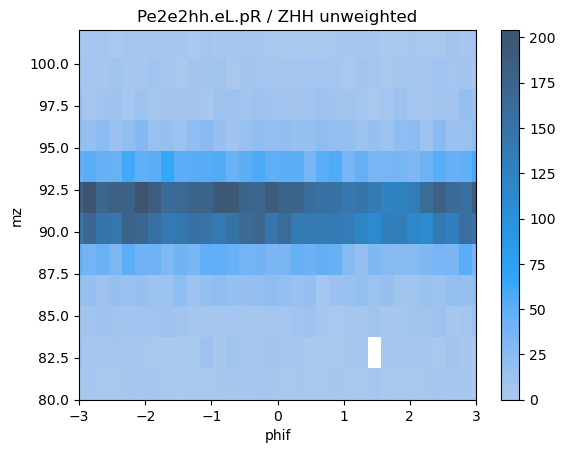

In [16]:
x = "phif"
y = "mz"
f = sns.histplot(x=data[x], y=data[y], bins=(32,128), cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="Pe2e2hh.eL.pR / ZHH unweighted")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

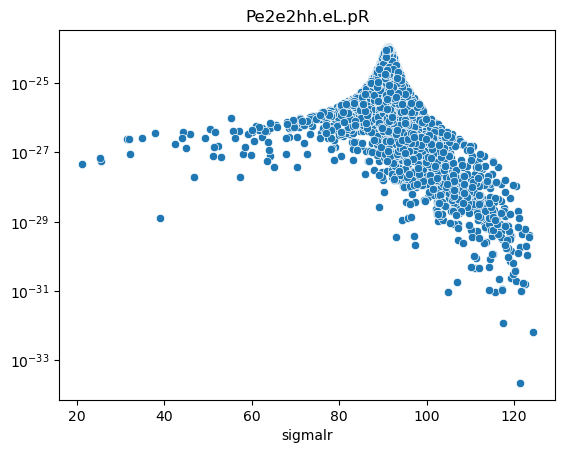

In [34]:
x = "sigmalr"
f = sns.scatterplot(x=data_old["mz"], y=data_old[x])
f.set(xlabel=x, title="Pe2e2hh.eL.pR", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

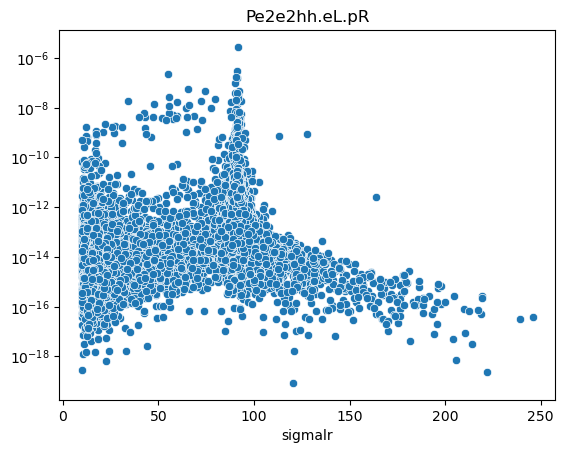

In [35]:
x = "sigmalr"
f = sns.scatterplot(x=data["mz"], y=data[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2ffqqh.eL.pR CORRECT'), None]

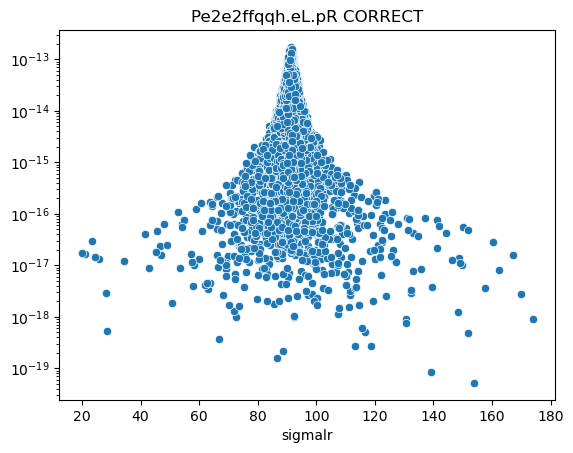

In [37]:
x = "sigmalr"
f = sns.scatterplot(x=data_inv["mz"], y=data_inv[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH weighted by sigmalr')]

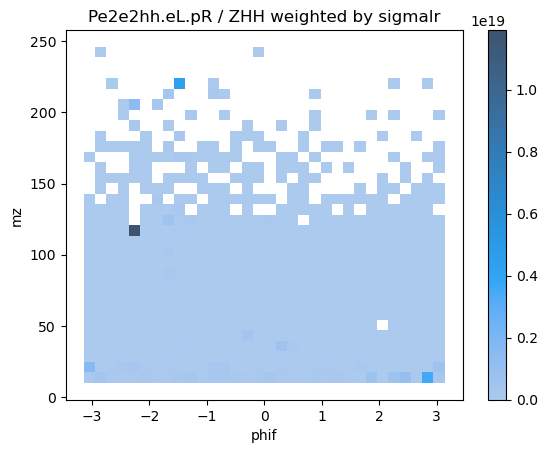

In [13]:
x = "phif"
y = "mz"
weight = "sigmalr"
f = sns.histplot(x=data[x], y=data[y], bins=32, cbar=True, weights=1/data[weight])
f.set(xlabel=x, ylabel=y, title="Pe2e2hh.eL.pR / ZHH weighted by " + weight)